### Данная тетрадка подготовлена Степаном Зиминым (tg @smzimin) и используется с его согласия. 

# Multivariate risk management. Part 2

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms
    
    
- Advanced models
    - Gaussian Mixture
    - Copulas
        - Explanation
        - Using GARCH as a univariate ditribution
        
        
- Backtesting
    
    
    
## References
- [Multivariate Models](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_06.pdf)
- [Copulas](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_07.pdf)
- [Multivariate Volatility Models](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-3.pdf)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'
# %config InlineBackend.figure_formats=["png"]

import warnings
warnings.filterwarnings("ignore")

## Recap -- what we want to do

We want to calculate some risk-metrics for our portfolio. Usually it is Value-at-Risk (VaR) -- a quantile on the distribution of P/L (profit and loss), or returns $r_t$:

$$\mathbf{P}[r_{t+h} \le VaR_{t+h}(q)] = q$$

and Expected Shortfall (ES) -- an expected loss conditional on VaR being violated:

$$ES = \mathbf{E}[r_{t+h} | r_{t+h} \le VaR_{t+h}(q)]$$

The differnce from the univariate case is that we consider portfolio returns $r^{\text{portfolio}}_t$, which depend on a vector of returns of each portfolio's component $r_t = \{r_t^{(j)}\}_{j=1}^n$:

$$ r^{\text{portfolio}}_t = \sum_{j=1}^n w_t^{(j)}r_t^{(j)} = w_t^Tr_t$$

(It's not 100% correct formula but rather an approximation, think why)

Let's try to model a random vector $r_t$ using different approaches

## Data

### Upload and visualize data

Get the data for the Dow Jones Industrial Average stocks by specifying the stock tickers, start date, and end date

https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI

In [2]:
# Students are advised to use other data sources. This is just for the sake of brevity.
# !pip install yfinance

In [3]:
import yfinance as yf

# selected_companies = ['AAPL',  'MSFT', 'MMM']
selected_companies = ['AAPL',  'MSFT', 'MMM', 'NKE', 'GS']

dwj_companies = 'VZ UNH JNJ PG MRK RTX KO WBA MMM WMT MSFT IBM INTC AAPL CSCO '
dwj_companies += 'NKE CAT PFE XOM MCD JPM HD V GS DIS AXP CVX TRV BA' # DOW

data = yf.download(dwj_companies, '2006-01-01','2012-12-31' , group_by="column")

data.head()

[*********************100%***********************]  29 of 29 completed


Adj Close                                                         \
                AAPL        AXP         BA        CAT       CSCO        CVX   
Date                                                                          
2006-01-03  2.285947  40.728039  50.119694  37.493546  12.619437  31.880825   
2006-01-04  2.292673  40.332096  50.639103  38.447094  12.908705  31.789089   
2006-01-05  2.274632  40.759087  50.041428  38.447094  13.270297  31.400568   
2006-01-06  2.333348  40.898834  49.344139  39.212532  13.574030  31.972567   
2006-01-09  2.325701  41.915886  48.931435  39.926086  13.783755  31.810684   

                                                         ...    Volume  \
                  DIS          GS         HD        IBM  ...       PFE   
Date                                                     ...             
2006-01-03  20.021519  103.255280  27.499191  48.988140  ...  40104489   
2006-01-04  19.685091  101.829102  26.992399  48.922474  ...  46345961   
2006-01-05  20.029726  101.789055  26.725693  49.250813  ...  44900716   
2006-01-06  20.300507  103.231285  26.925728  50.713425  ...  30064191   
2006-01-09  20.513849  104.473213  27.219116  49.985100  ...  29596215   

                                                                       \
                 PG      RTX      TRV      UNH   V        VZ      WBA   
Date                                                                    
2006-01-03  9741500  5905519  3843800  8070500 NaN  14348241  5217300   
2006-01-04  6746400  4948941  2285900  5585200 NaN  34475165  5900300   
2006-01-05  8936100  4955932  3069300  5624200 NaN  22976845  4568900   
2006-01-06  8825800  4567263  2641500  5577600 NaN  64153275  4205500   
2006-01-09  7715700  3920381  2201500  8828900 NaN  19569726  4396800   

                                
                 WMT       XOM  
Date                            
2006-01-03  23413500  23871000  
2006-01-04  14087200  19086500  
2006-01-05  20758200  17158400  
2006-01-06  21129800  17368600  
2006-01-09  14877400  17339100  

[5 rows x 174 columns]

In [4]:
prices = data['Adj Close'].dropna()

print(prices.shape)
prices.head()

(1205, 29)


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2008-03-19,3.965466,33.308510,54.094543,49.762348,17.696136,47.255268,26.503475,135.638138,18.873508,72.017212,...,11.213464,44.601818,30.894314,32.758877,29.514645,12.828160,16.476049,25.902071,36.930485,50.754345
2008-03-20,4.075560,36.464897,55.088787,49.823093,17.913094,48.016975,27.063410,146.343231,19.731392,72.873291,...,11.202581,45.627899,31.006632,33.732960,29.323687,14.610481,16.940361,26.186874,38.712296,51.097000
2008-03-24,4.266996,37.598976,56.186161,51.314671,18.542250,48.478630,27.182186,145.732239,20.575216,73.322845,...,11.213464,46.022545,31.604208,33.662354,29.647472,13.561524,17.339008,27.489803,39.003178,51.668087
2008-03-25,4.311340,37.678276,55.898899,51.726368,18.621805,48.784470,27.216118,146.343231,20.223625,72.651558,...,11.305959,45.739708,31.523333,33.711773,29.290483,14.360735,17.306183,27.062614,38.581379,51.217220
2008-03-26,4.436113,35.973190,56.193485,52.212341,17.920324,49.026814,26.944633,142.962280,19.801710,71.998795,...,11.256990,45.805496,31.276209,33.563538,28.310812,14.521935,16.949736,27.027012,38.472279,51.854420


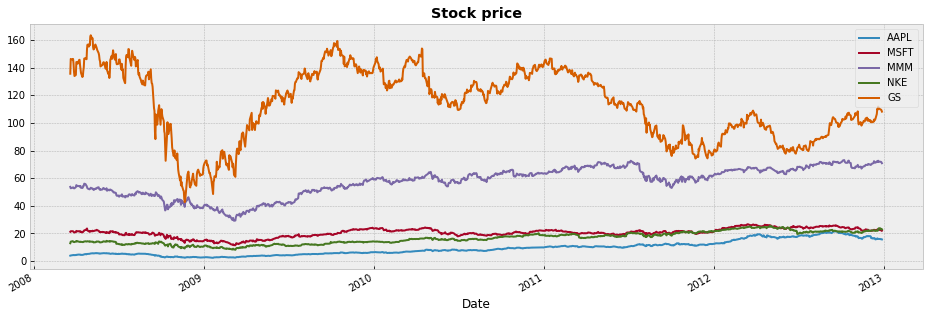

In [5]:
prices.loc[:,selected_companies].plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

We convert datetime index to period

In [6]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2008-03-19', '2008-03-20', '2008-03-24', '2008-03-25',
               '2008-03-26', '2008-03-27', '2008-03-28', '2008-03-31',
               '2008-04-01', '2008-04-02',
               ...
               '2012-12-14', '2012-12-17', '2012-12-18', '2012-12-19',
               '2012-12-20', '2012-12-21', '2012-12-24', '2012-12-26',
               '2012-12-27', '2012-12-28'],
              dtype='datetime64[ns]', name='Date', length=1205, freq=None)
PeriodIndex(['2008-03-19', '2008-03-20', '2008-03-24', '2008-03-25',
             '2008-03-26', '2008-03-27', '2008-03-28', '2008-03-31',
             '2008-04-01', '2008-04-02',
             ...
             '2012-12-14', '2012-12-17', '2012-12-18', '2012-12-19',
             '2012-12-20', '2012-12-21', '2012-12-24', '2012-12-26',
             '2012-12-27', '2012-12-28'],
            dtype='period[D]', name='Date', length=1205)


In [7]:
returns = prices.pct_change().dropna()

returns.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2008-03-20,0.027763,0.094762,0.018380,0.001221,0.012260,0.016119,0.021127,0.078924,0.045454,0.011887,...,-0.000970,0.023005,0.003636,0.029735,-0.006470,0.138938,0.028181,0.010995,0.048248,0.006751
2008-03-24,0.046972,0.031101,0.019920,0.029937,0.035123,0.009614,0.004389,-0.004175,0.042766,0.006169,...,0.000971,0.008649,0.019273,-0.002093,0.011042,-0.071795,0.023532,0.049755,0.007514,0.011177
2008-03-25,0.010392,0.002109,-0.005113,0.008023,0.004290,0.006309,0.001248,0.004193,-0.017088,-0.009155,...,0.008249,-0.006146,-0.002559,0.001468,-0.012041,0.058932,-0.001893,-0.015540,-0.010814,-0.008726
2008-03-26,0.028941,-0.045254,0.005270,0.009395,-0.037670,0.004968,-0.009975,-0.023103,-0.020862,-0.008985,...,-0.004331,0.001438,-0.007839,-0.004397,-0.033447,0.011225,-0.020597,-0.001316,-0.002828,0.012441
2008-03-27,-0.033159,-0.011684,-0.027261,-0.004266,-0.024213,-0.006591,-0.011965,-0.041828,-0.013139,-0.011890,...,-0.006283,-0.003303,-0.002873,-0.001893,-0.002933,-0.016416,-0.004980,-0.018441,-0.010019,-0.000695


### Plot histograms

Look at histograms and scatterplots for some stocks

<Figure size 504x504 with 0 Axes>

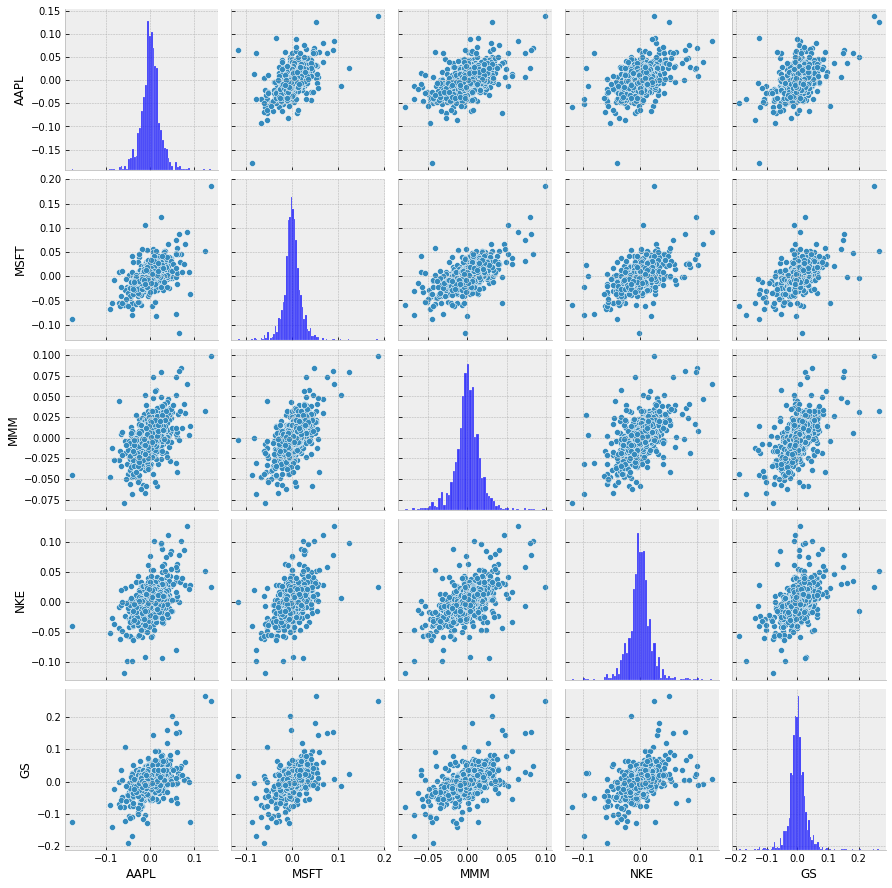

In [8]:
fig = plt.figure(figsize=(7, 7))

sns.pairplot(returns[selected_companies])

plt.show()

Let's consider a case of equally-weighted portfolio

In [9]:
# w = np.ones(shape=(returns.shape[1],)) / returns.shape[1]

w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

# w_temp = np.ones(shape=(len(selected_companies),)) / len(selected_companies)

w_temp = 1 / prices[selected_companies].iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns[selected_companies].values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)
print(w_temp)

AAPL    0.188841
AXP     0.022482
BA      0.013843
CAT     0.015048
CSCO    0.042317
CVX     0.015847
DIS     0.028255
GS      0.005521
HD      0.039677
IBM     0.010398
INTC    0.054113
JNJ     0.017465
JPM     0.025249
KO      0.038657
MCD     0.020968
MMM     0.013931
MRK     0.030466
MSFT    0.035246
NKE     0.057868
PFE     0.066781
PG      0.016790
RTX     0.024239
TRV     0.022859
UNH     0.025372
V       0.058375
VZ      0.045450
WBA     0.028911
WMT     0.020277
XOM     0.014754
Name: 2008-03-19, dtype: float64
AAPL    0.626531
MSFT    0.116939
MMM     0.046221
NKE     0.191992
GS      0.018317
Name: 2008-03-19, dtype: float64


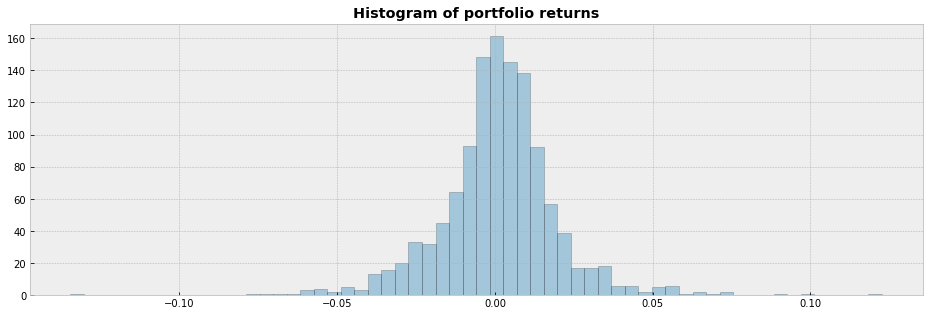

In [10]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of portfolio returns", weight="bold")

plt.show()

And for additional vizualization let's look at join distribution of only two stocks

In [11]:
ticker_one = 'AAPL'
ticker_two = 'MMM'

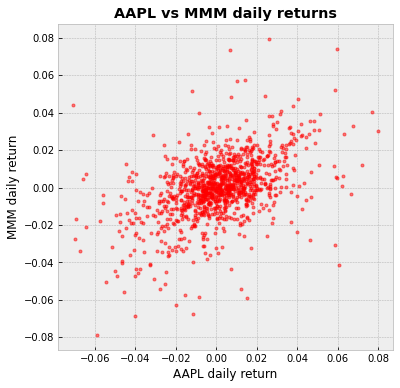

In [12]:
my_lim = 0.08

idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)

x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]

fig = plt.figure(figsize=(6, 6))

plt.plot(x, y, "r.", alpha=0.5)

plt.xlabel("{} daily return".format(ticker_one))
plt.ylabel("{} daily return".format(ticker_two))
plt.title("{} vs {} daily returns".format(ticker_one, ticker_two), weight="bold")

plt.show()

In [13]:
alpha = 0.1

## Advanced models

### Gaussian Mixture

We assume that

$$r_t \sim \sum_{k=1}^d p_kN(\mu_k, \Sigma_k)$$


where $p_k$ are $d$ mixture weights, which are probabilities that sum to 1, $\mu_k \in \mathbb{R}^n$ are mean vectors and $\Sigma_k$ are covariance matrices of each mixture component

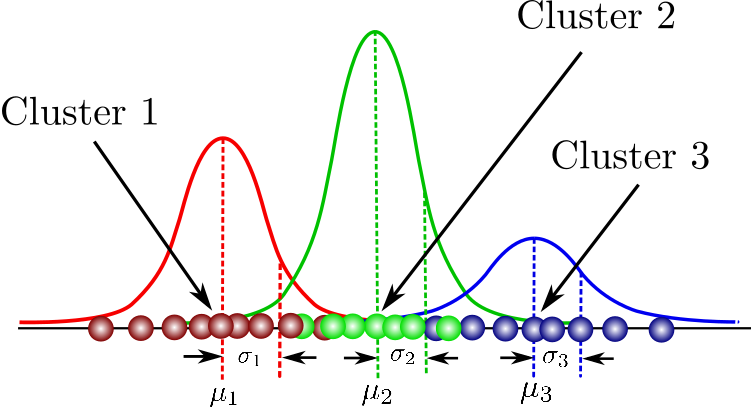

In [14]:
from sklearn.mixture import GaussianMixture

n_samples = 10 ** 4

gmm = GaussianMixture(n_components=15, covariance_type='full', n_init=10, random_state=42) # full spherical
gmm.fit(returns[selected_companies].values)

return_simulations = gmm.sample(n_samples=n_samples)[0]

return_simulations = pd.DataFrame(return_simulations, columns=selected_companies)

In [15]:
return_simulations

,AAPL,MSFT,MMM,NKE,GS
0,-0.042279,-0.020252,-0.024737,-0.013354,-0.033656
1,-0.017216,-0.013040,-0.006343,0.002504,-0.022091
2,0.008416,0.002657,-0.004166,0.007022,-0.002969
3,0.006979,-0.008788,-0.019043,-0.021969,-0.062146
4,0.011738,-0.009110,-0.005916,0.006499,0.030037
...,...,...,...,...,...
9995,0.011607,0.099010,0.007279,-0.006548,0.018398
9996,-0.006364,0.044913,-0.007490,-0.006664,0.000341
9997,-0.000950,0.069965,-0.001307,-0.006366,0.002407
9998,-0.018493,0.022310,0.011089,-0.004093,-0.023198


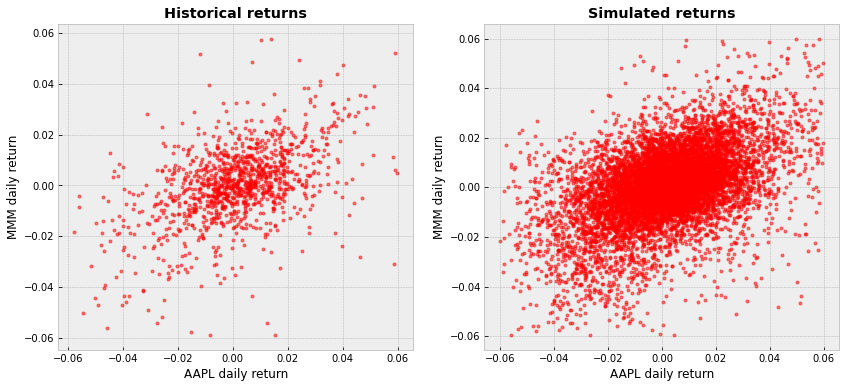

In [19]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.06
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.06
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

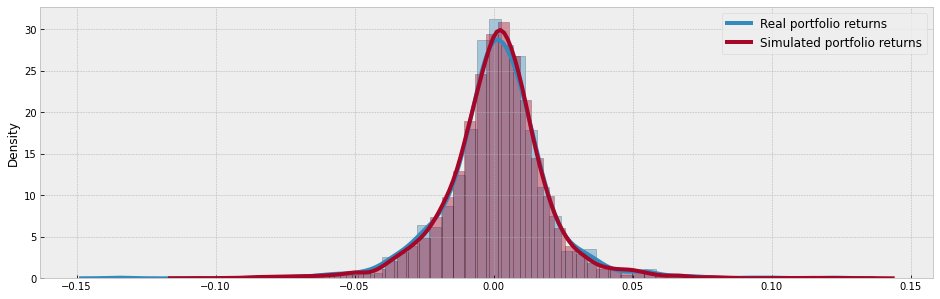

In [17]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [18]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.02096590022086871
-0.019811345921558574


#### Wrapping into functions

In [20]:
def make_gmm_simulations(returns, n_samples=10**3):

    n_components = 6

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=3, random_state=42) # full spherical
    gmm.fit(returns.values)

    return_simulations = gmm.sample(n_samples=n_samples)[0]

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)

In [21]:
VaR_gmm_6 = calc_VaR(returns[selected_companies], make_gmm_simulations, w_temp, level=alpha)

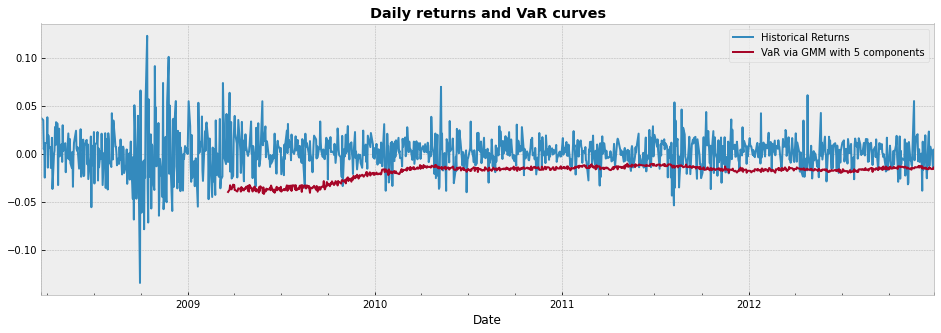

In [22]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_multy_normal.plot()
VaR_gmm_6.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
#             'VaR via Multivariate normal',
            'VaR via GMM with 5 components'])

plt.show()

### Copulas

How do we model nonlinear dependence more formally? We can use copulas, which allow us to create multivariate distributions with a range of types of dependence.

We start with the marginal distributions of each random variable and end up with a copula function. The copula function joins the random variables into a single multivariate distribution by using their correlations.

The random variables are transformed to uniform distributions using the probability integral transformation. The copula models the dependence structure between these uniforms. Since the probability integral transform is invertible, the copula also describes the dependence between the original random variables

We assume that $$r_t \sim C\left(F_{1,t}\left(r_t^{(1)}\right),\dots,F_{n,t}\left(r_t^{(n)}\right);\theta\right),$$

where $C$ is a copula function and $F_{i,t}$ are marginal distribution of $r_t^{(j)}$.

Note that we can construct a joint distribution from any marginal distributions and any copula, and we can also extract the implied copula and marginal distributions from any joint distribution


Steps to implement in practice:
1. Model univariate distributions
2. Transform returns to margins using univariate CDF's
3. Fit copula with the data
4. Generate pseudo-random samples of margins
5. Go back from samples of margins to samples of returns using univariate inverse CDF's
6. ...
7. PROFIT

In [ ]:
# https://copulae.readthedocs.io/en/latest/examples/usage_guide.html
# !pip install copulae

#### Steps 1 & 2

In [22]:
import scipy.stats as ss

cdfs = returns[selected_companies].copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = ss.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = ss.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [23]:
returns[selected_companies]

,AAPL,MSFT,MMM,NKE,GS
Date,,,,,
2008-03-20,0.027763,0.019567,-0.018750,0.087983,0.078923
2008-03-24,0.046972,-0.000342,0.008464,0.026906,-0.004175
2008-03-25,0.010393,-0.001029,0.004324,-0.010278,0.004193
2008-03-26,0.028940,-0.019904,-0.004052,-0.030715,-0.023103
2008-03-27,-0.033158,-0.017857,-0.010170,-0.004376,-0.041828
...,...,...,...,...,...
2012-12-21,-0.004600,-0.008309,-0.010942,0.061616,-0.009868
2012-12-24,0.001617,-0.014207,0.000967,0.004758,-0.007007
2012-12-26,-0.013784,-0.007391,-0.001288,-0.027841,-0.002980


In [24]:
cdfs

,AAPL,MSFT,MMM,NKE,GS
Date,,,,,
2008-03-20,0.912250,0.893451,0.087350,0.995966,0.984957
2008-03-24,0.975114,0.490650,0.733750,0.928471,0.419192
2008-03-25,0.698999,0.470197,0.617316,0.232781,0.598662
2008-03-26,0.919294,0.104144,0.346261,0.050055,0.143366
2008-03-27,0.049044,0.123269,0.197141,0.362670,0.055779
...,...,...,...,...,...
2012-12-21,0.358430,0.275094,0.183025,0.989549,0.308687
2012-12-24,0.502577,0.167623,0.507774,0.611879,0.361685
2012-12-26,0.193763,0.296296,0.432833,0.060820,0.444559


In [25]:
distribution_params

{'AAPL': (3.5574770613065123, 0.0015091176275329426, 0.015553078768233277),
 'MSFT': (2.8449950595548303, -2.895134615555861e-05, 0.01225847221850764),
 'MMM': (2.9791537985822165, 0.0007347018573227128, 0.010979604230242572),
 'NKE': (2.8395216976428763, 0.0006827624124882956, 0.01304266545917043),
 'GS': (2.3174219855588802, -0.00042013737105669894, 0.01648634338561339)}

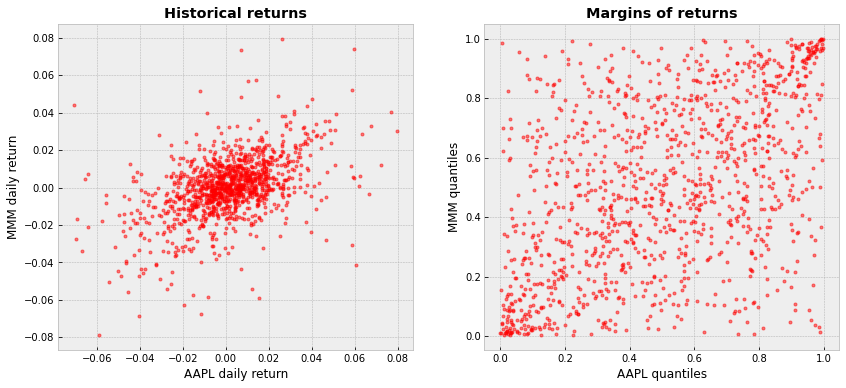

In [26]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} quantiles".format(ticker_one))
plt2.set_ylabel("{} quantiles".format(ticker_two))
plt2.set_title("Margins of returns", weight="bold")

plt.show()

In [ ]:
# h = sns.jointplot(x, y, kind='kde', xlim=(0, 1), ylim=(0, 1), stat_func=None)
# h.set_axis_labels('Maximum river level', 'Probablity of flooding', fontsize=16)

In [37]:
# !pip install --upgrade numpy

     |████████████████████████████████| 16.8 MB 875 kB/s eta 0:00:01
ERROR: tsfresh 0.19.0 has requirement statsmodels>=0.13, but you'll have statsmodels 0.12.1 which is incompatible.
ERROR: sktime 0.10.1 has requirement numpy<1.22,>=1.21.0, but you'll have numpy 1.22.3 which is incompatible.
ERROR: numba 0.54.1 has requirement numpy<1.21,>=1.17, but you'll have numpy 1.22.3 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


#### Step 3

In [27]:
from copulae import NormalCopula

cop = NormalCopula(dim=cdfs.shape[1])
cop.fit(cdfs)

cop.summary()

              AAPL         MSFT          MMM          NKE           GS
count  1204.000000  1204.000000  1204.000000  1204.000000  1204.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288555     0.288555     0.288555     0.288555     0.288555
min       0.000830     0.000830     0.000830     0.000830     0.000830
25%       0.250415     0.250415     0.250415     0.250415     0.250415
50%       0.500000     0.503320     0.500000     0.500000     0.500000
75%       0.749585     0.749585     0.749585     0.749585     0.749585
max       0.999170     0.999170     0.999170     0.999170     0.999170


1.000000,0.524699,0.511226,0.488384,0.453887
0.524699,1.000000,0.612781,0.527851,0.506688
0.511226,0.612781,1.000000,0.573100,0.557418
0.488384,0.527851,0.573100,1.000000,0.493505
0.453887,0.506688,0.557418,0.493505,1.000000


#### Step 4

In [28]:
n_samples = 10 ** 4

copula_simulations = cop.random(n_samples, seed=42)

copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

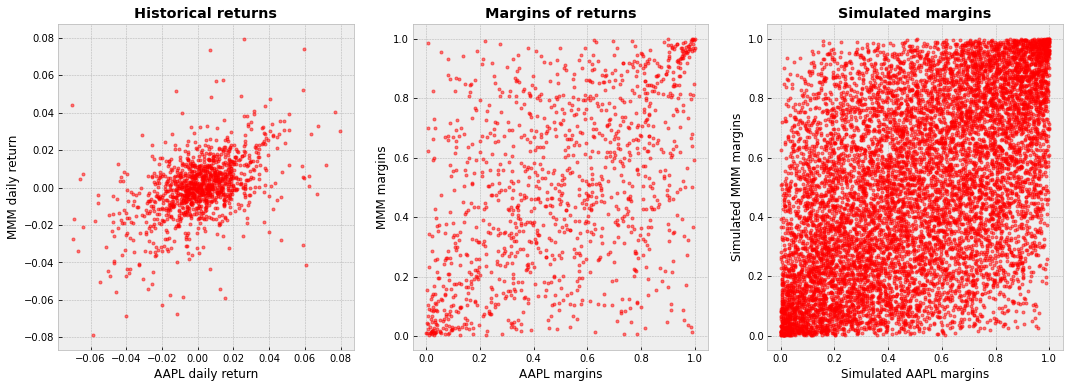

In [29]:
fig = plt.figure(figsize=(18, 6))

plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)


plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} margins".format(ticker_one))
plt2.set_ylabel("{} margins".format(ticker_two))
plt2.set_title("Margins of returns", weight="bold")


x = copula_simulations[ticker_one]
y = copula_simulations[ticker_two]
plt3.plot(x, y, "r.", alpha=0.5)

plt3.set_xlabel("Simulated {} margins".format(ticker_one))
plt3.set_ylabel("Simulated {} margins".format(ticker_two))
plt3.set_title("Simulated margins", weight="bold")

plt.show()

#### Step 5

In [30]:
return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations[col] = ss.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

In [31]:
copula_simulations

,AAPL,MSFT,MMM,NKE,GS
0,0.358770,0.153674,0.225805,0.699013,0.383633
1,0.787764,0.658109,0.671541,0.595092,0.158848
2,0.334154,0.966624,0.509737,0.505394,0.626182
3,0.314767,0.902351,0.550825,0.684993,0.775167
4,0.061907,0.367023,0.123553,0.059288,0.109941
...,...,...,...,...,...
9995,0.889445,0.847138,0.265882,0.953349,0.914493
9996,0.504068,0.449576,0.563068,0.651286,0.269305
9997,0.707213,0.094817,0.360503,0.705453,0.490025
9998,0.374374,0.439316,0.051568,0.720697,0.803817


In [32]:
return_simulations

,AAPL,MSFT,MMM,NKE,GS
0,-0.004584,-0.015232,-0.008750,0.008308,-0.005901
1,0.015520,0.005506,0.006133,0.004125,-0.021300
2,-0.005738,0.035494,0.001026,0.000875,0.005551
3,-0.006682,0.020640,0.002260,0.007697,0.014494
4,-0.029718,-0.004622,-0.015033,-0.028210,-0.027926
...,...,...,...,...,...
9995,0.024551,0.015237,-0.007010,0.033152,0.031928
9996,0.001679,-0.001725,0.002632,0.006297,-0.012246
9997,0.010816,-0.021064,-0.003576,0.008596,-0.000878
9998,-0.003874,-0.002074,-0.024803,0.009296,0.016819


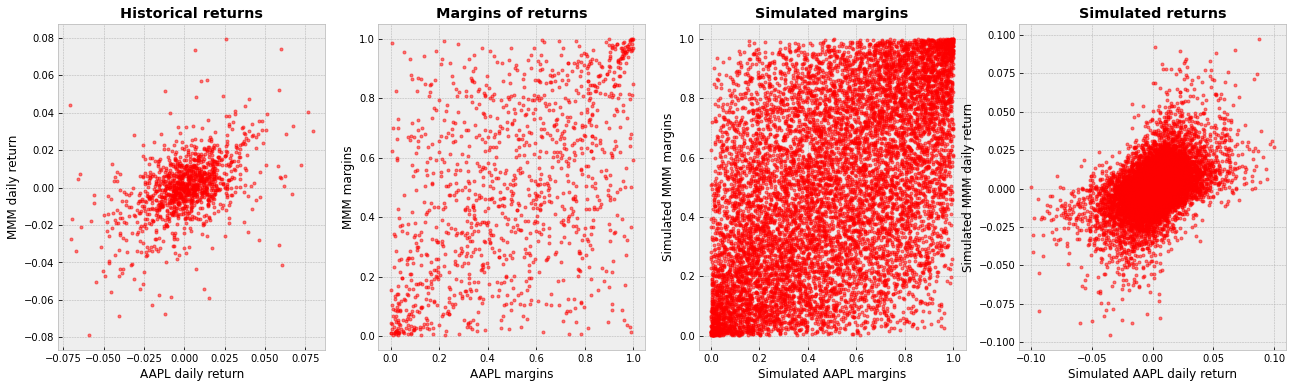

In [33]:
fig = plt.figure(figsize=(22, 6))

plt1 = fig.add_subplot(1,4,1)
plt2 = fig.add_subplot(1,4,2)
plt3 = fig.add_subplot(1,4,3)
plt4 = fig.add_subplot(1,4,4)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} margins".format(ticker_one))
plt2.set_ylabel("{} margins".format(ticker_two))
plt2.set_title("Margins of returns", weight="bold")


x = copula_simulations[ticker_one]
y = copula_simulations[ticker_two]
plt3.plot(x, y, "r.", alpha=0.5)

plt3.set_xlabel("Simulated {} margins".format(ticker_one))
plt3.set_ylabel("Simulated {} margins".format(ticker_two))
plt3.set_title("Simulated margins", weight="bold")


my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt4.plot(x, y, "r.", alpha=0.5)

plt4.set_xlabel("Simulated {} daily return".format(ticker_one))
plt4.set_ylabel("Simulated {} daily return".format(ticker_two))
plt4.set_title("Simulated returns", weight="bold")

plt.show()

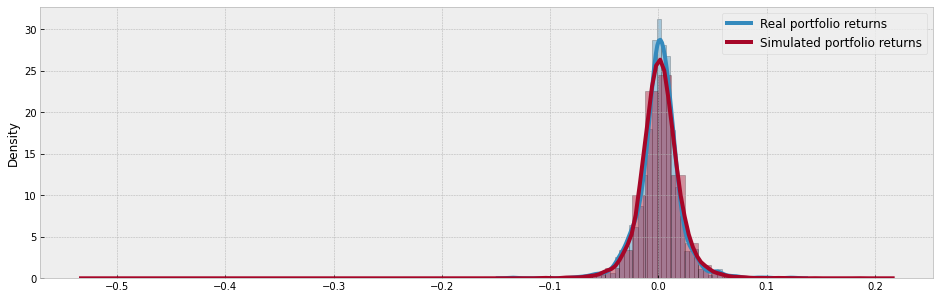

In [34]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [35]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.02096590022086871
-0.01944134656465688


#### Combining all steps together + trying different copulas and univariate distributions

In [36]:
from copulae import StudentCopula, ClaytonCopula, GumbelCopula

In [37]:
univariate_dist = 'gennorm' # gennorm
cop = ClaytonCopula(dim=cdfs.shape[1])
n_samples = 10 ** 4

cdfs = returns[selected_companies].copy()
distribution_params = {}

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = ss.t.fit(cdfs[col])
        distribution_params[col] = (t_df, t_mean, t_sigma)
        cdfs[col] = ss.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = ss.gennorm.fit(cdfs[col])
        distribution_params[col] = (beta, loc, scale)
        cdfs[col] = ss.gennorm.cdf(cdfs[col], beta, loc, scale)

cop.fit(cdfs)

copula_simulations = cop.random(n_samples, seed=42)
copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = distribution_params[col]
        return_simulations[col] = ss.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = distribution_params[col]
        return_simulations[col] = ss.gennorm.ppf(copula_simulations[col], beta, loc, scale)

              AAPL         MSFT          MMM          NKE           GS
count  1204.000000  1204.000000  1204.000000  1204.000000  1204.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288555     0.288555     0.288555     0.288555     0.288555
min       0.000830     0.000830     0.000830     0.000830     0.000830
25%       0.250415     0.250415     0.250415     0.250415     0.250415
50%       0.500000     0.503320     0.500000     0.500000     0.500000
75%       0.749585     0.749585     0.749585     0.749585     0.749585
max       0.999170     0.999170     0.999170     0.999170     0.999170


In [38]:
selected_companies

['AAPL', 'MSFT', 'MMM', 'NKE', 'GS']

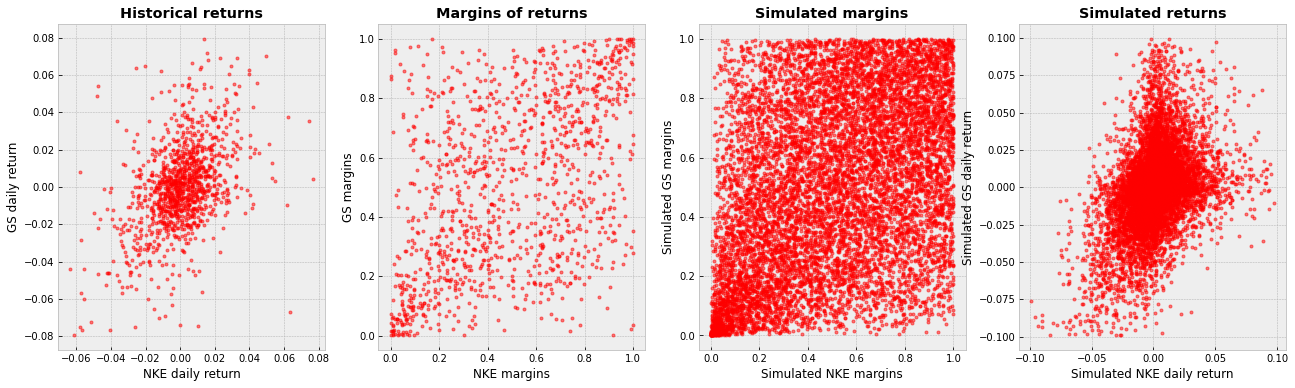

In [39]:
ticker_one = 'NKE'
ticker_two = 'GS'

fig = plt.figure(figsize=(22, 6))

plt1 = fig.add_subplot(1,4,1)
plt2 = fig.add_subplot(1,4,2)
plt3 = fig.add_subplot(1,4,3)
plt4 = fig.add_subplot(1,4,4)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} margins".format(ticker_one))
plt2.set_ylabel("{} margins".format(ticker_two))
plt2.set_title("Margins of returns", weight="bold")


x = copula_simulations[ticker_one]
y = copula_simulations[ticker_two]
plt3.plot(x, y, "r.", alpha=0.5)

plt3.set_xlabel("Simulated {} margins".format(ticker_one))
plt3.set_ylabel("Simulated {} margins".format(ticker_two))
plt3.set_title("Simulated margins", weight="bold")


my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt4.plot(x, y, "r.", alpha=0.5)

plt4.set_xlabel("Simulated {} daily return".format(ticker_one))
plt4.set_ylabel("Simulated {} daily return".format(ticker_two))
plt4.set_title("Simulated returns", weight="bold")

plt.show()

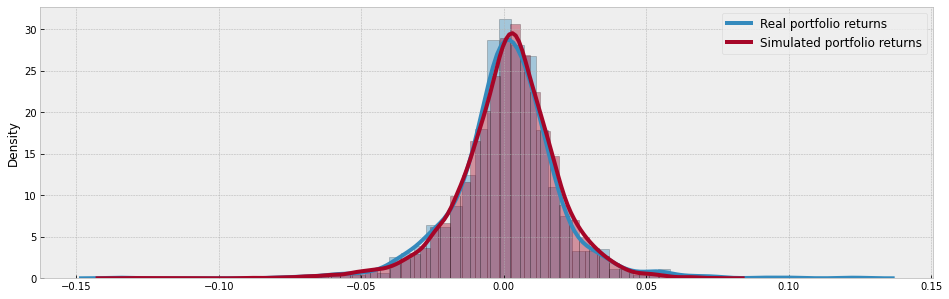

In [40]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [41]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.02096590022086871
-0.01920735599684501


#### Using GARCH as univariate distribution

In [46]:
from arch import arch_model 

def get_garch_residuals(ret, dist):

    scaling_const = 10.0 / ret.std()
    
    # объявляем GARCH модель
        
    am = arch_model(ret * scaling_const,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])
        
    return cdf, am, res, scaling_const


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [53]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()[:-1]
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res, scaling_const)
            cdfs[col] = cdf

    # фитим копулу
    cop.fit(cdfs)
    

    # делаем сэмплирование marginals из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)
    

    return_simulations = copula_simulations.copy()

    # трансформируем marginals в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res, scaling_const = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

In [54]:
from copulae import StudentCopula, ClaytonCopula, GumbelCopula

In [55]:
return_simulations = make_copula_simulation(returns[selected_companies], ClaytonCopula,
                                            n_samples=10**4, univariate_dist='garch')

              AAPL         MSFT          MMM          NKE           GS
count  1203.000000  1203.000000  1203.000000  1203.000000  1203.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288555     0.288555     0.288555     0.288555     0.288555
min       0.000831     0.000831     0.000831     0.000831     0.000831
25%       0.250415     0.250415     0.250415     0.250415     0.250415
50%       0.500000     0.500000     0.500000     0.500000     0.500000
75%       0.749585     0.749585     0.749585     0.749585     0.749585
max       0.999169     0.999169     0.999169     0.999169     0.999169


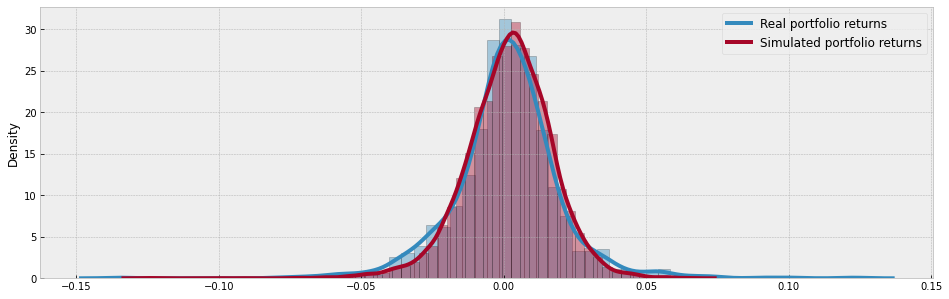

In [57]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

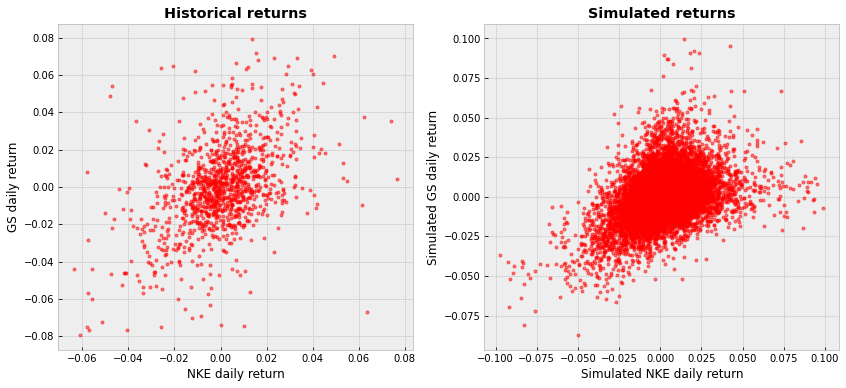

In [58]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")

my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("Simulated {} daily return".format(ticker_one))
plt2.set_ylabel("Simulated {} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

In [59]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.02096590022086871
-0.01656251062893966


In [60]:
def make_copula_simulation_wrap(returns):
    
    return_simulations = make_copula_simulation(returns, ClaytonCopula,
                                            n_samples=10**3, univariate_dist='garch')
    
    return return_simulations

VaR_copulanorm_garch = calc_VaR(returns[selected_companies], make_copula_simulation_wrap, w_temp)

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288097    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.994048    0.996032    0.982143    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.994048    0.996032    0.938492    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.994048    0.996032    0.934524    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288071    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.968254    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.946429    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.938492    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.934524    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287744    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288095    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.980159    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288090    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288090    0.288102    0.288102    0.287942    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.976190    0.996032    0.996032    0.946429    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.288102    0.287923    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288065    0.288102    0.288102    0.288097    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.966270    0.996032    0.996032    0.982143    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288065    0.288102    0.288102    0.288100    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288086    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.974206    0.996032    0.996032    0.994048    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288018    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288101    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288102    0.288100    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.990079    0.996032    0.996032    0.986111    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.986111    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288102    0.288102    0.288056
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.988095    0.996032    0.996032    0.996032    0.964286
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288102    0.288102    0.288099
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288090
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.976190
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288095
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288005
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.954365
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288005
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.287991
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.952381
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.287711
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.287744
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.930556
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.287942
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.992063    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288099
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.984127
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288082
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288101
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.990079
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288101
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288029
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.958333
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288029
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.992063
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.992063
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288101
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.996032    0.996032    0.996032
             AAPL        MSFT         MMM         NKE          GS
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288102    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

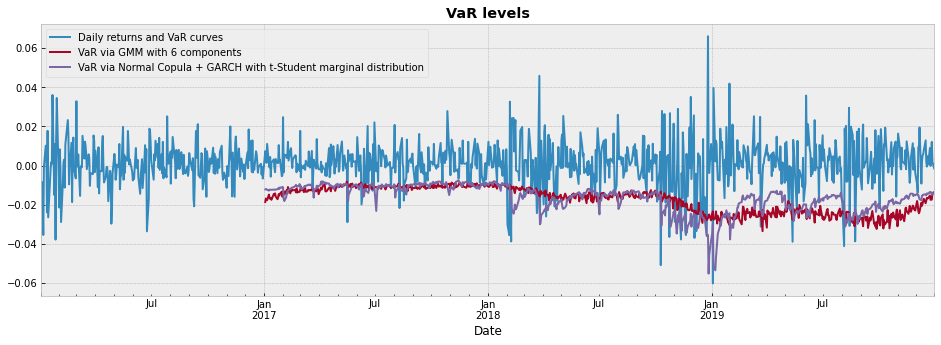

In [51]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_multy_normal.plot()
VaR_gmm_6.plot()
VaR_copulanorm_garch.plot()

plt.title("VaR levels", weight="bold")

plt.legend(['Daily returns and VaR curves',
#             'VaR via Multivariate normal',
            'VaR via GMM with 6 components',
           'VaR via Normal Copula + GARCH with t-Student marginal distribution'])

plt.show()

## Backtesting VaR

In [52]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))


def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [53]:
backtest_results(
    portfolio_real_returns_selected, 
    var_curve=VaR_gmm_6,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 5.00%
Observed share of violations: 6.64%

Test for coverage isn't passed

Test for independence is passed


In [54]:
backtest_results(
    portfolio_real_returns_selected, 
    var_curve=VaR_copulanorm_garch,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 5.00%
Observed share of violations: 5.84%

Test for coverage is passed

Test for independence is passed
